# Assignment 1
#### Sunil Simha

I'm assuming problem 0 is not really something to be shown on this notebook. All code is present on my GitHub repository (https://github.com/SunilSimha/dynamics).

In [3]:
#imports
from astropy.coordinates import CartesianRepresentation as cart
from astropy import units as u
from astropy.units.astrophys import Msun, astronomical_unit as AU, Mearth
from astropy.constants import G
import numpy as np
import matplotlib.pyplot as plt

#plot defaults
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['font.size']=14

#My code
import orbconvert as orb
import helpers as hp

----

## Problem 1
### a) Function that converts cartesian coordinates to Keplerian elements
I prefer giving in both masses separately instead of using one parameter because it seems a more natural thing to do. Also, I'm heavily relying on `astropy` `BaseRepresentation`, `units` and `Quantities` because then I don't really have to keep track of units (I like the help from `astropy`).

In [4]:
#Present in orbconvert.py
def cart2els(pos,vel,M,m,nat_units=False):
    """
    Converts cartesian coordinates to
    orbital elements assuming the cartesian
    coordinates are set in a frame that is
    centered on one of the objects.
    Parameters
    ----------
    pos: astropy.coordinates.CartesianRepresentation
        The position vector. The components must have
        units of distance.
    vel: astropy.coordinates.CartesianRepresentation
        The velocity vector. The components must have
        units of speed (distance/time).
    M: astropy.Quantity
        Mass of the object at (0,0).
    m: astropy.Quantity
        Mass of the object at the input
        coordinates.
    nat_units: bool, optional
        If true, returns answer in units where a = 1 and
        time is rescaled to sqrt(mu)t.

    Outputs
    -------
    els: astropy.Quantity list/array
        Returns an array of orbital elements
        for the osculating orbit.
    tau: astropy.Quantity 
        Some time parameter.
    """
    #import pdb
    #pdb.set_trace()
    mu = G*(M+m)
    R = pos.norm()
    V = vel.norm()
    a = 1/(2/R-V*V/mu)

    #Rescaling
    #t = t*np.sqrt(mu/a**3)
    pos = pos/a
    R = (R/a).decompose()
    vel = vel*np.sqrt(a/mu)
    V = (vel.norm()).decompose()
    #rDot = (pos.dot(vel)).decompose()/R
    
    #Rescaled angular momentum
    hvec = pos.cross(vel)
    h = (hvec.norm()).decompose()
    #pdb.set_trace()
    #Orbital elements
    e = np.sqrt(1-h*h)
    I = np.arccos(hvec.z/h)
    if I.value==0:
        Omega = 0*u.rad
        omegaPlusf = np.arccos(pos.x/R)
    else:
        Omega = np.arcsin(np.sign(hvec.z)*hvec.x/h/np.sin(I))
        omegaPlusf = np.arcsin(pos.z/R/np.sin(I))
    #because cos(Omega)= 1
    #pdb.set_trace()
    f = np.arccos(((1-e*e)/R-1)/e)
    omega = omegaPlusf - f
    
    f = hp.niceangle(f)
    I = hp.niceangle(I)
    Omega = hp.niceangle(Omega)
    omega = hp.niceangle(omega)

    #E = np.arccos((1-R)/e)
    #tau = t-E.value+e*np.sin(E)

    if nat_units:
        els = [1,e,I,Omega,omega,f]
    else:
        els = [a,e,I,Omega,omega,f] #(tau*np.sqrt(a**3/mu)).decompose()]
    return els

### The inverse function
Converting Keplerian elements to cartesian vectors

In [5]:
def els2cart(els,M,m):
    """
    The inverse function of cart2els.
    Converts orbital elements ot cartesian
    coordinates at the central mass
    Parameters
    ----------
    els: list of astropy Quantities
        Orbital elements in the same order
        as cart2els's output (with tau). If els
        is in natural units where a = 1, then
        the scaled positions and velocities are returned
    Returns
    -------
    pos: astropy.coordinates.CartesianRepresentation
        The position vector. The components must have
        units of distance.
    vel: astropy.coordinates.CartesianRepresentation
        The velocity vector. The components must have
        units of speed (distance/time).
    """
    #unpack els
    a,e,I,Omega,omega,f = els
    #tau = els[6]

    #Define constants
    mu = G*(M+m)

    if a == 1:
        scaled = True
    else:
        try:
            a.unit
            scaled = False
        except:
            raise TypeError("Please use astropy.Quantity objects to specify a's units or rescale to set a to 1 to use natural units.")
    
    #Work as if a is scaled and then rescale it
    #to standard units at the end.

    #Get h and its components
    #h = np.sqrt(1-e*e)
    #hz = h*np.cos(I)
    #hx = h*np.sign(hz)*np.sin(Omega)*np.sin(I)
    #hy = -h*np.sign(hz)*np.cos(Omega)*np.sin(I)
    #hvec = cart(x = hx,y = hy, z= hz)

    #Getting R and its components
    omegaPlusf = omega+f
    R = (1-e*e)/(e*np.cos(f)+1)
    z = R*np.sin(I)*np.sin(omegaPlusf)
    y = R*(np.cos(omegaPlusf)*np.sin(Omega)+np.sin(omegaPlusf)*np.cos(I)*np.cos(Omega))
    x = R*(np.cos(omegaPlusf)*np.cos(Omega)-np.sin(omegaPlusf)*np.cos(I)*np.sin(Omega))
    pos = cart(x = x,y = y, z = z)

    #Getting V and its components. I'm going to use Ruth's formula here.
    #n = 1 #In scaled units.
    xorbdot = -np.sin(f)/np.sqrt(1-e*e)
    yorbdot = (e+np.cos(f))/np.sqrt(1-e*e)
    vx = np.cos(Omega)*(xorbdot*np.cos(omega) - yorbdot*np.sin(omega)) - np.sin(Omega)* ((xorbdot*np.sin(omega) + yorbdot*np.cos(omega))*np.cos(I))   
    vy = np.sin(Omega)*(xorbdot*np.cos(omega) - yorbdot*np.sin(omega)) + np.cos(Omega)* ((xorbdot*np.sin(omega) + yorbdot*np.cos(omega))*np.cos(I))
    vz = (xorbdot*np.sin(omega) + yorbdot*np.cos(omega))*np.sin(I)
    vel = cart(x=vx,y=vy,z=vz)

    pos = a*pos
    vel = vel*(np.sqrt(mu/a)).to(u.km/u.s)
    return pos, vel

#### Testing if they're actually inverses of each other

In [6]:
#initialise
pos = cart(x=1,y=1,z=0)*AU
vel = cart(x=1,y=30,z=1)*u.km/u.s
M = 1*Msun
m = 1*Mearth

In [7]:
els = cart2els(pos,vel,M,m)
els

[<Quantity 2.51602548 AU>,
 <Quantity 0.78887205>,
 <Quantity 0.04872738 rad>,
 <Quantity 0.78539816 rad>,
 <Quantity 4.28348945 rad>,
 <Quantity 1.99969586 rad>]

In [8]:
newpos, newvel = els2cart(els,M,m)
newpos, newvel

(<CartesianRepresentation (x, y, z) in AU
     (1., 1., -1.68716305e-17)>, <CartesianRepresentation (x, y, z) in km / s
     (1., 30., 1.)>)

They work okay.

### c) Converting from heliocentric to barycentric frame and back
These functions take the cartesian state vectors and transform them between the two frames. (They're pretty small. I just like to have a lot of documentation). One gets both masses as paramters or one could just input the required mass ratio of $M/(m+M)$ as a parameter. 

In [9]:
def bary2helio(pos_h,vel_h,M,m):
    """
    Converts position and velocity vectors in
    heliocentric frame to the barycentric frame.
    Parameters
    ----------
    pos_h: astropy.coordinates.CartesianRepresentation
        The position vector in the heliocentric frame.
        The components must have units of distance.
    vel_h: astropy.coordinates.CartesianRepresentation
        The velocity vector in the heliocentric frame.
        The components must have units of speed (distance/time).
    M: astropy.Quantity
        Central mass.
    m: astropy.Quantity
        Mass of the object at pos_h.
    Returns
    -------
    pos_b: astropy.coordinates.CartesianRepresentation
        Position in the barycentric frame
    vel_b: velocity in the barycentric frame
    """
    return pos_h*(M+m)/M, vel_h*(M+m)/M

def helio2bary(pos_h,vel_h,M,m):
    """
    Converts position and velocity vectors in
    heliocentric frame to the barycentric frame.
    Parameters
    ----------
    pos_h: astropy.coordinates.CartesianRepresentation
        The position vector in the heliocentric frame.
        The components must have units of distance.
    vel_h: astropy.coordinates.CartesianRepresentation
        The velocity vector in the heliocentric frame.
        The components must have units of speed (distance/time).
    M: astropy.Quantity
        Central mass.
    m: astropy.Quantity
        Mass of the object at pos_h.
    Returns
    -------
    pos_b: astropy.coordinates.CartesianRepresentation
        Position in the barycentric frame
    vel_b: velocity in the barycentric frame
    """
    return pos_h*M/(M+m), vel_h*M/(M+m)

----
## Problem 2)
### a) Solving the Kepler equation
I first write a second-order Newton-Rhapson solver in the `helpers.py` module and then call it in `solve_kepler` from `orbconvert.py`. Here are the functions.

In [10]:
def newton_rhapson(func,x0,deriv=None,tol=1e-15,maxiter=20):
    """
    An implementation of the newton-rhapson method of
    numerical root finding.
    Paramters
    ---------
    func: python callable function
        The function whose root is to be found
    x0: float
        Initial guess for root finding
    deriv: python callable function, optional
        The derivative of func. If not given,
        a first order numerical derivative
        is used. 
    tol: float, optional
        Tolerance for relative error between
        successive iterations
    maxiter: int, optional
        Maximum number of iterations this function
        is allowed to go through.
    Returns
    -------
    root: float
        Estimate of the root
    """
    #import pdb
    #pdb.set_trace()
    i = maxiter
    if deriv is None:
        deriv = lambda x: 1e15*(func(x+1e-15)-func(x))
    error = np.inf
    while (np.abs(error)>tol) and (i>0):
        dx =  -func(x0)/deriv(x0)
        error = dx/x0
        x0 = x0+dx
        i -=  1
    root = x0
    if i==0:
        raise UserWarning("Root not found to specified tolerance within {} iterations".format(maxiter))
        return root
    else:
        return root
    
def solve_kepler(M,e,E0=None,tol=1e-15,maxiter=20):
    """
    Solves the Kepler equation ($M = E - e\sinE$)
    for E given M and e using the Newton-Rhapson
    method (superconvergent).
    Parameters
    ----------
    M: float
        Value of n(t-t0). Must be dimensionless
    e: float
        Orbital eccentricity
    E0: float, optional
        Initial guess for E0. Defaults to 0.5 if
        not given
    tol: float, optional
        Tolerance for relative error between
        successive iterations
    maxiter: int, optional
        Maximum number of iterations this function
        is allowed to go through.
    Returns
    -------
    root: float
        Value of
    """
    if E0 is None:
        E0 = M
    func = lambda E: M-E+e*np.sin(E)
    deriv = lambda E: -1+e*np.cos(E)

    root = hp.newton_rhapson(func,E0,deriv,tol,maxiter)
    return root

### b) Testing the root-solver out
Trying to compute the orbital radial distance of the planet using the `solve_kepler` function, I wrote another function that does this for a given array of time values.

In [11]:
def get_rad(t_array,M,m,a,e,t0=0*u.s):
    """
    Returns an array of radial distances
    at the instances in the input time
    array.
    Paramters
    ---------
    t_array: astropy.Quantity array
        An array of time instances at which
        the radial distances are to be found
    M: astropy.Quantity
        central mass
    m: astropy.Quantity
        Mass of the orbiting body
    a: astropy.Quantity
        Semi-major axis
    e: float
        Orbital eccentricity
    Returns
    -------
    radArray: astropy.Quantity array
        Array of radial distances.
    """
    #First, all computations are done in
    #natural units. Only while returning will the
    #answer be given in standard units
    #import pdb
    mu = G*(M+m)
    t_scaled = (t_array*np.sqrt(mu/a**3)).decompose().value
    t0_scaled = (t0*np.sqrt(mu/a**3)).decompose().value
    numT = len(t_array)
    radArray = np.zeros(numT)*AU

    for count, t in enumerate(t_scaled):
        Mval = t-t0_scaled
        E = solve_kepler(Mval,e)
        radArray[count] = a*(1-e*np.cos(E))
    
    return radArray

/home/sunil/Python/dynamics/helpers.py:104: RuntimeWarning: invalid value encountered in double_scalars
  error = dx/x0


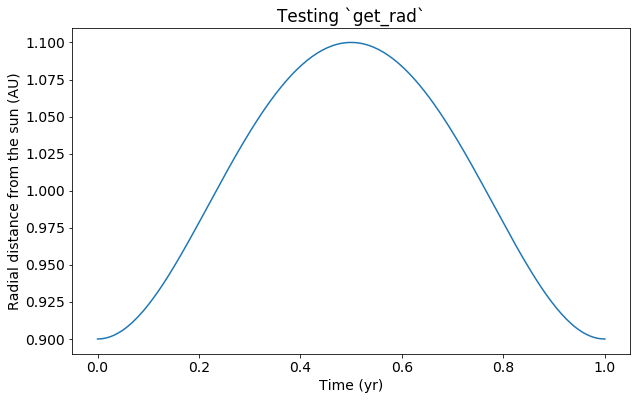

In [12]:
#Actual testing
#Setting up input
a = 1*AU
e = 0.1
m = 1*u.astrophys.M_jup
M = 1*Msun
t_array = np.linspace(0,1,200)*u.yr
#gettign output
rad = orb.get_rad(t_array,M,m,a,e)
#plotting those results
plt.plot(t_array,rad)
plt.xlabel("Time (yr)")
plt.ylabel("Radial distance from the sun (AU)")
plt.title(r"Testing `get_rad`")
plt.show()

It works!
### c) The Sun's wobble
_Barycentric Frame_

$\vec{R_\odot}$: Solar postion

$\vec{R_p}$: Planet position

_Heliocentric frame_

$\vec{r} = \vec{R_p}-\vec{R_\odot}$: position of the planet

Converting between the two frames is something that we covered early in class. Here are the expressions.
$\vec{R_\odot} = -\vec{r}\left(\frac{m}{M_\odot+m}\right)$

$\vec{R_p} = \vec{r}\left(\frac{M_\odot}{M_\odot+m}\right)$

Now that we already have $r$ from the previous part of the problem, we can get the change in radial distance of the Sun and the planet from the barycenter.

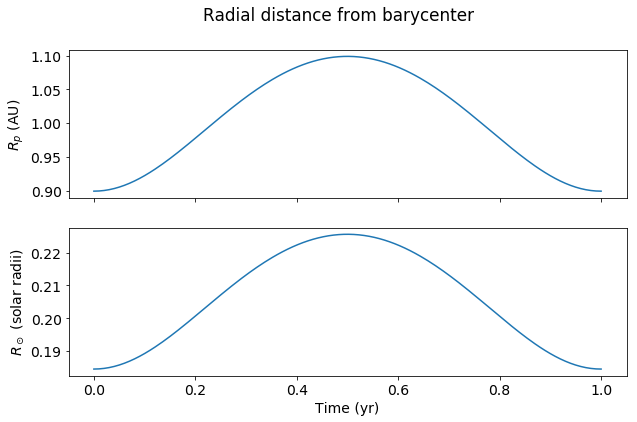

In [13]:
Rsol = (rad*m/(M+m)).to(u.astrophys.solRad) #Converts directly to solar radii
Rplanet = rad*M/(M+m)
fig, axs = plt.subplots(ncols=1,nrows=2,sharex=True)
ax = axs[0]
ax.plot(t_array,Rplanet)
ax.set_ylabel("$R_p$ (AU)")

ax = axs[1]
ax.plot(t_array,Rsol)
ax.set_ylabel(r"$R_\odot$ (solar radii)")
ax.set_xlabel("Time (yr)")
fig.suptitle("Radial distance from barycenter")
plt.show()

The wobble is about 20% of the solar radius.

### d) Testing out converters from P1
Redoing those same calculations but using the converters from Q1 to see if this actually works

/home/sunil/Python/dynamics/helpers.py:104: RuntimeWarning: invalid value encountered in double_scalars
  error = dx/x0


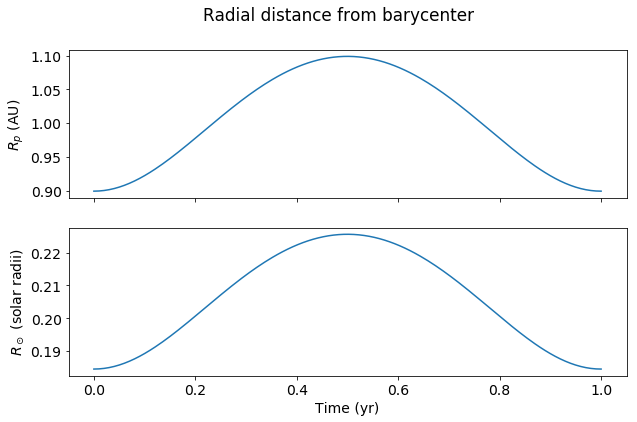

In [14]:
# I'm setting I, Omega and omega to 0 because I get to choose
# the reference plane.
# I just need to compute f for all values of t. In hindsight, I
# see why Ruth computed both r and f in one function. So I'll modify
# get_rad.

def get_rad(t_array,M,m,a,e,t0=0*u.s,f_flag=False):
    """
    Returns an array of radial distances
    at the instances in the input time
    array.
    Paramters
    ---------
    t_array: astropy.Quantity array
        An array of time instances at which
        the radial distances are to be found
    M: astropy.Quantity
        central mass
    m: astropy.Quantity
        Mass of the orbiting body
    a: astropy.Quantity
        Semi-major axis
    e: float
        Orbital eccentricity
    f_flag: bool, optional
        If true, also returns an
        array of f values.
    Returns
    -------
    radArray: astropy.Quantity array
        Array of radial distances.
    fArray: astropy.Quantity array
        Array of f values. Computed only if
        f_flag is set to `True`.
    """
    #First, all computations are done in
    #natural units. Only while returning will the
    #answer be given in standard units
    #import pdb
    mu = G*(M+m)
    t_scaled = (t_array*np.sqrt(mu/a**3)).decompose().value
    t0_scaled = (t0*np.sqrt(mu/a**3)).decompose().value
    numT = len(t_array)
    radArray = np.zeros(numT)*AU
    if f_flag:
        fArray = np.zeros(numT)*u.rad

    for count, t in enumerate(t_scaled):
        Mval = t-t0_scaled
        E = solve_kepler(Mval,e)
        radArray[count] = a*(1-e*np.cos(E))
        if f_flag:
            if E == 0:
                fArray[count] = 0*u.rad
            if E == np.pi:
                fArray[count] = np.pi*u.rad
            if E < np.pi:
                fArray[count] = np.arccos(a*(np.cos(E)-e)/radArray[count])
            else:
                fArray[count] = 2*np.pi*u.rad - np.arccos(a*(np.cos(E)-e)/radArray[count])
    if f_flag:
        return radArray, fArray
    else:
        return radArray

a = 1*AU
e = 0.1
I = 0*u.rad
Omega = 0*u.rad
omega = 0*u.rad
_, fArray = get_rad(t_array,M,m,a,e,f_flag=True)

#Now to get position vectors and hence their norm
radArray = np.zeros(len(t_array))*AU
radSol = np.zeros(len(t_array))*u.astrophys.solRad #For barycentric solar position
radPlanet = np.zeros(len(t_array))*AU #For barycentric planetary position
for count, f in enumerate(fArray):
    els = [a,e,I,Omega,omega,f]
    pos_h, vel_h = els2cart(els,M,m) #Heliocentric vectors of the planet
    pos_bp, vel_bp = helio2bary(pos_h,vel_h,M,m) #Barycentric planetary coordinates
    pos_bS, vel_bS = -pos_bp*m/M, -vel_bp*m/M #Barycentric solar coordinates
    radSol[count] = pos_bS.norm()
    #pdb.set_trace()
    radPlanet[count] = pos_bp.norm()

fig, axs = plt.subplots(ncols=1,nrows=2,sharex=True)
ax = axs[0]
ax.plot(t_array,radPlanet)
ax.set_ylabel("$R_p$ (AU)")

ax = axs[1]
ax.plot(t_array,radSol)
ax.set_ylabel(r"$R_\odot$ (solar radii)")
ax.set_xlabel("Time (yr)")
fig.suptitle("Radial distance from barycenter")
plt.show()


It works!

---
## Problem 3
### a) Trying out rebound
I'm just going to copy and paste the snippet from the problem and run it here.

1.0 -0.0008991008991008992 0.0 0.0 0.0 -0.00110498924021966 0.0
0.001 0.899100899100899 0.0 0.0 0.0 1.1049892402196597 0.0
---------------------------------
REBOUND version:     	3.6.6
REBOUND built on:    	Sep 27 2018 13:20:02
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+03
Current timestep:    	0.094656
---------------------------------
<rebound.Particle object, m=1.0 x=0.00010251203730028162 y=-0.0009939900462534242 z=0.0 vx=0.0009992357033508606 vy=2.5994643547914688e-06 vz=0.0>
<rebound.Particle object, m=0.001 x=-0.1025120373004084 y=0.9939900462530453 z=0.0 vx=-0.9992357033508603 vy=-0.002599464354792025 vz=0.0>
---------------------------------
<rebound.Particle object, m=1.0 x=0.00010251203730028162 y=-0.0009939900462534242 z=0.0 vx=0.0009992357033508606 vy=2.5994643547914688e-06 vz=0.0>
<rebound.Particle object, m=0.001 x=-0.1025120373004084 y=0.9939900462530453 z=0.0 vx=-0.9992357033508603 vy=-0.002599464354792025 vz=0.0>
<reb

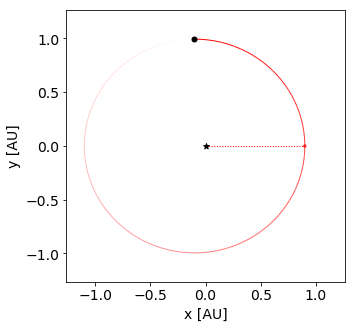

In [15]:
import rebound as rb
sim = rb.Simulation()
sim.add(m=1.0)
sim.add(m=1.0e-3, a=1.0, e=0.1)
sim.move_to_com() # moves all particles to the barycentric frame
for p in sim.particles:
    print(p.m, p.x, p.y, p.z, p.vx, p.vy, p.vz)
sim.integrate(1000.)
sim.status()
for p in sim.particles:
    print(p)
for o in sim.calculate_orbits(primary=sim.particles[0]): print(o)
fig = rb.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)

Okay, so there are some deprecations in `calculate_orbits` so instead of using the `heliocentric` flag, I'm passing `sim.particles[0]`. Alas, `REBOUND` doesn't use astropy Quantities :'(
### b) Calculating orbits from P2 with rebound

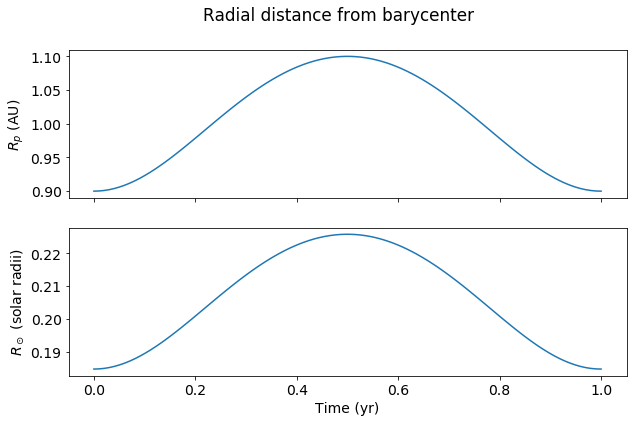

In [16]:
sim = rb.Simulation()
t_array = np.linspace(0,1,100)
Mjup = (1*u.astrophys.Mjup).to(Msun).value
rsol = (1*u.astrophys.solRad).to(AU).value
sim.units =("yr","AU","Msun")
sim.add(m=1.0)
sim.add(m=Mjup, a=1.0, e=0.1)
sim.move_to_com()

rad_planet = np.zeros(len(t_array))
rad_sol = np.zeros(len(t_array))
for count, t in enumerate(t_array):
    sim.integrate(t)
    orbits = sim.calculate_orbits() #primary is CoM by default
    rad_planet[count] = orbits[0].d
    rad_sol[count] = rad_planet[count]*Mjup/rsol #Msun is 1 here. Converting length units to solar radii

fig, axs = plt.subplots(ncols=1,nrows=2,sharex=True)
ax = axs[0]
ax.plot(t_array,rad_planet)
ax.set_ylabel("$R_p$ (AU)")

ax = axs[1]
ax.plot(t_array,rad_sol)
ax.set_ylabel(r"$R_\odot$ (solar radii)")
ax.set_xlabel("Time (yr)")
fig.suptitle("Radial distance from barycenter")
plt.show()

### c) Comparing my code's output against rebound
I'm assuming I just need ot compare the x components of the planet's state vectors in the barycentric frame.

/home/sunil/Python/dynamics/helpers.py:104: RuntimeWarning: invalid value encountered in double_scalars
  error = dx/x0


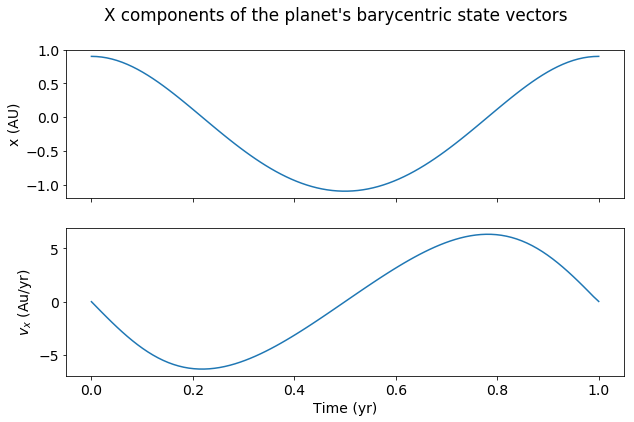

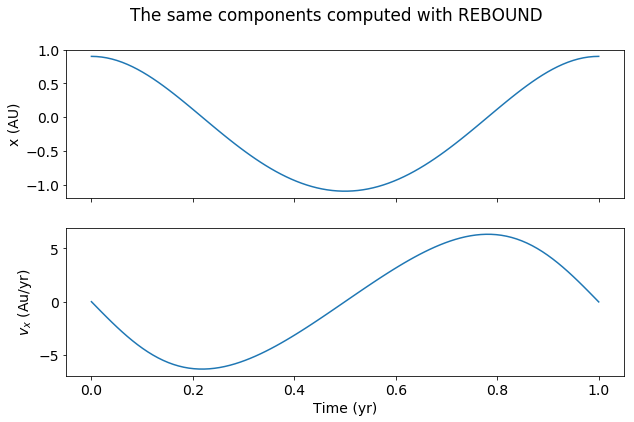

In [17]:
t_array = np.linspace(0,1,100)*u.yr

a = 1*AU
e = 0.1
I = 0*u.rad
Omega = 0*u.rad
omega = 0*u.rad
_, fArray = get_rad(t_array,M,m,a,e,f_flag=True)

#To get the x components of position and velocity:
x_array_mine = np.zeros(len(t_array))*AU
vx_array_mine = np.zeros(len(t_array))*AU/u.yr 
radPlanet = np.zeros(len(t_array))*AU
for count, f in enumerate(fArray):
    els = [a,e,I,Omega,omega,f]
    pos_h, vel_h = els2cart(els,M,m) #Heliocentric vectors of the planet
    pos_bp, vel_bp = helio2bary(pos_h,vel_h,M,m) #Barycentric planetary coordinates
    x_array_mine[count] = pos_bp.x
    vx_array_mine[count] = vel_bp.x

#Now using REBOUND
x_array_reb = np.zeros(len(t_array))
vx_array_reb = np.zeros(len(t_array)) 

sim = rb.Simulation()
sim.units =("yr","AU","Msun")
sim.add(m=1.0)
sim.add(m=Mjup, a=1.0, e=0.1)
sim.move_to_com()
for count, t in enumerate(t_array):
    sim.integrate(t.value)
    x_array_reb[count] = sim.particles[1].x
    vx_array_reb[count] = sim.particles[1].vx

fig, axs = plt.subplots(ncols=1,nrows=2,sharex=True)
ax = axs[0]
ax.plot(t_array,x_array_mine)
ax.set_ylabel("x (AU)")

ax = axs[1]
ax.plot(t_array,vx_array_mine)
ax.set_ylabel(r"$v_x$ (Au/yr)")
ax.set_xlabel("Time (yr)")
fig.suptitle("X components of the planet's barycentric state vectors")
plt.show()

fig, axs = plt.subplots(ncols=1,nrows=2,sharex=True)
ax = axs[0]
ax.plot(t_array,x_array_reb)
ax.set_ylabel("x (AU)")

ax = axs[1]
ax.plot(t_array,vx_array_reb)
ax.set_ylabel(r"$v_x$ (Au/yr)")
ax.set_xlabel("Time (yr)")
fig.suptitle("The same components computed with REBOUND")
plt.show()

---
## Problem 4
### a) Coordinate transformation from exoplanet orbit to our sky
In the plane of the exoplanet's orbit (in its "heliocentric" frame), its position vector is given by $x^T = (r\cos f,r\sin f,0)$. If its orbital elements are $a,e,I,\Omega,\omega, f$, in our frame of reference,
$$
\begin{aligned}
(x,y,z)^T&=P_z(\Omega)P_x(I)P_z(\omega)\\
z &= r\sin(\omega+f)\sin(I)\\
\end{aligned}
$$
Going from heliocentric to barycentric frame:
$$z_1 = z \frac{m_2}{m_1+m_2}=r\sin(\omega+f)\sin(I)\frac{m_2}{m_1+m_2}$$

### b) Computing radial velocity
$$
\begin{aligned}
\dot r &= \frac{na}{\sqrt{1-e^2}}e\sin f\\
r\dot f &= \frac{na}{\sqrt{1-e^2}}(1+e\cos f)\\
\end{aligned}
$$

$$
\begin{aligned}
\dot z_1 &= \dot r\sin(\omega+f)\sin I\frac{m_2}{m_1+m_2}+r\dot f \cos(\omega+f)\sin I\frac{m_2}{m_1+m_2}\\
&= \sin I\frac{m_2}{m_1+m_2}\frac{na}{\sqrt{1-e^2}}\left(e\sin f\sin(\omega+f)+(1+e\cos f)\cos(\omega+f)\right)\\
&= \sin I\frac{m_2}{m_1+m_2}\frac{na}{\sqrt{1-e^2}}\left(e\cos\omega+\cos(\omega+f)\right)\\
& = K\left(e\cos\omega+\cos(\omega+f)\right)\\
\end{aligned}
$$
Of course, inlcuding the radial velocity of the barycenter gives an additional (hopefully) constant component $V_0$ say.

### c) Degeneracy between $m_2$ and $I$
One can measure $n$ independently and extract it from $K$. One can also assume $m_1>>m_2$ (which is most likely true) and get $a$ and $m_1$ out of K. This leaves $m_2\sin I$. Now it is extremely difficult to get the value of $I$ because it requires measurement of the oscillations in proper motion of the star. Thus, we are left with two degenerate quantities.

### d) Scaling relations
For a circular orbit, $e =0$.
$$
\begin{aligned}
K&=\sin I\frac{m_2}{m_1+m_2}na\\
m_2\sin I &= K(m_1+m_2)/na\\
&\approx Km_1/na\\
&\propto Km_1T/a\\
&\propto Km_1^{2/3}T^{1/3}\\
\end{aligned}
$$
The proportionality constant being $(2\pi G)^{-1/3}$. Converting $m_2$ to jupiter mass units, $m_1$ to solar mass units and $T$ to years, we get:
$$
\frac{m_2\sin I}{M_{Jup}} = \left(\frac{K}{28.4 {\rm m/s}}\right) \left(\frac{m_1}{M_\odot}\right)^{2/3}\left(\frac{T}{\rm yr}\right)^{1/3}
$$

---
## Problem 5
### a) Estimating $m_2\sin I$ for Pegasi 51b
The amplitude of the oscillations looks like 60 m/s and the time period is given to be 4.2 days. If Peg 51 is a solar mass star, the value of $m_2\sin I$ is like $60/28.4\times(4.4/365)^{1/3}M_{jup}=0.48M_{jup}$

### b) Modelling on REBOUND

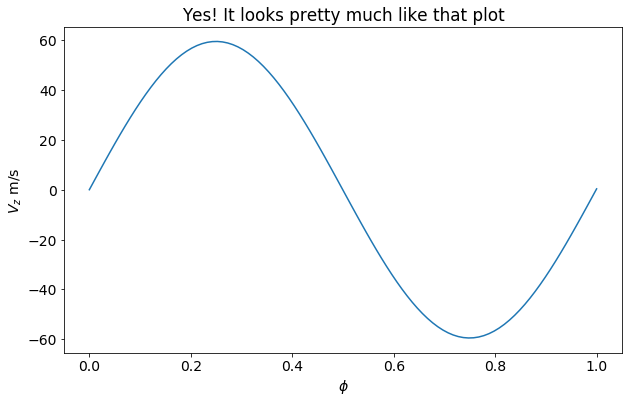

In [32]:
#I'm assuming a value of 90 degrees for inclination
#(meaning the system is edge on) because I can exploit the
#degeneracy to my advantage.
I = 0
#the semi-major axis just depends on the period and stellar mass
a = ((G*1*Msun*(4.4*u.day)**2/4/np.pi**2)**(1/3)).to(AU).value
t_array = np.linspace(0,4.4/365,100) #In units of years

sim = rb.Simulation()
sim.units =("yr","AU","Msun")
sim.add(m=1.0)
sim.add(m=0.48*Mjup, a=a)
sim.move_to_com()

v_array = np.zeros(len(t_array))
for count, t in enumerate(t_array):
    sim.integrate(t)
    v_array[count] = sim.particles[0].vx

auyr2ms = (1*AU/u.yr).decompose().value
plt.plot(t_array*365/4.4,v_array*auyr2ms)
plt.xlabel("$\phi$")
plt.ylabel("$V_z$ m/s")
plt.title("Yes! It looks pretty much like that plot")
plt.show()

A bit of phase difference.
### c) How close is my answer to Mayor and Queloz's?
Their answer is $m_2\sin i = 0.47 \pm 0.02 M_{Jup}$. So pretty close